In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import pickle
import torch
sys.path.append(r"C:\Users\Alireza\Documents\Git\Cosine-Project")
from inSilico_experiments.utils.pothook_analysis_lib import *
from torchvision.transforms import ToTensor, ToPILImage, Pad, Compose
from torchvision.utils import make_grid
from core.utils.CNN_scorers import resize_and_pad_tsr

In [2]:
# load metadata 
data_path = r"N:\PonceLab\Users\Alireza\insilico_experiments\Alexnet_remonstration_across_different_layer_062023\post_processed"

#metadata_df_cosine_intralayer = pd.read_hdf(os.path.join(data_path, "metadata_df_inter_layer_with_normalized_dist.h5"), key="metadata_df")
#metadata_df_cosine_crosslayer = pd.read_hdf(os.path.join(data_path, "metadata_df_intera_layer_with_normalized_dist.h5"), key="metadata_df")
# concatenate the two dataframes
#metadata_df_cosine = pd.concat([metadata_df_cosine_intralayer, metadata_df_cosine_crosslayer], ignore_index=False)
metadata_df_cosine = pd.read_hdf(os.path.join(data_path, "metadata_df_with_sim_index.h5"), key="metadata_df")
#metadata_df_cosine = metadata_df_cosine_most
save_root = r"N:\PonceLab\Users\Alireza\matrial_for_slides\population_sussses"


In [4]:
metadata_df_cosine.head(10)

,output_type,trget_imge_name,similarity_metric,pop_size,pop_resampling_id,gan_name,layer_name,layer_short,net_name,img_size,...,sub_pop_type,gen_rerun_id,data_root,l2_distance,alexnet,vgg16,resnet50,resnet101,pixel_dist_normalized,sim_index
1687416128_4419577,target_img,imagenet_18,None,128,0,fc6,.features.Conv2d3,conv2,alexnet,None,...,random,None,N:\PonceLab\Users\Alireza\insilico_experiments...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1687416128_4445313,target_img_RF_masked,imagenet_18,None,128,0,fc6,.features.Conv2d3,conv2,alexnet,None,...,random,None,N:\PonceLab\Users\Alireza\insilico_experiments...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1687416147_5999399,best_gen_imgs,imagenet_18,cosine,128,0,fc6,.features.Conv2d3,conv2,alexnet,None,...,random,0,N:\PonceLab\Users\Alireza\insilico_experiments...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1687416147_8799687,best_gen_imgs_RF_masked,imagenet_18,cosine,128,0,fc6,.features.Conv2d3,conv2,alexnet,None,...,random,0,N:\PonceLab\Users\Alireza\insilico_experiments...,8.271968,NaN,NaN,NaN,NaN,0.540106,0.67306
1687416147_6061125,last_gen_mean_imgs,imagenet_18,cosine,128,0,fc6,.features.Conv2d3,conv2,alexnet,None,...,random,0,N:\PonceLab\Users\Alireza\insilico_experiments...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1687416147_2366897,last_gen_mean_imgs_RF_masked,imagenet_18,cosine,128,0,fc6,.features.Conv2d3,conv2,alexnet,None,...,random,0,N:\PonceLab\Users\Alireza\insilico_experiments...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1687416147_8863634,last_gen_all_imgs,imagenet_18,cosine,128,0,fc6,.features.Conv2d3,conv2,alexnet,None,...,random,0,N:\PonceLab\Users\Alireza\insilico_experiments...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1687416147_4825076,best_in_each_gen_imgs,imagenet_18,cosine,128,0,fc6,.features.Conv2d3,conv2,alexnet,None,...,random,0,N:\PonceLab\Users\Alireza\insilico_experiments...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1687416147_1406172,last_gen_all_imgs_RF_masked,imagenet_18,cosine,128,0,fc6,.features.Conv2d3,conv2,alexnet,None,...,random,0,N:\PonceLab\Users\Alireza\insilico_experiments...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1687416147_3691035,best_in_each_gen_imgs_RF_masked,imagenet_18,cosine,128,0,fc6,.features.Conv2d3,conv2,alexnet,None,...,random,0,N:\PonceLab\Users\Alireza\insilico_experiments...,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1]:
# print some good examples of the algorithm success

import matplotlib as mpl
import time
color_map_name_cosine = "jet"
pading_cmap_cosine=mpl.colormaps[color_map_name_cosine]
color_map_name_MSE = "jet"
pading_cmap_MSE=mpl.colormaps[color_map_name_MSE]

def addhock_normalization(inval, minval, maxval):
    return (inval - minval) / (maxval - minval)

cosine_min = .75
cosine_max = 1
MSE_min = -25
MSE_max = 3
image_name_list = metadata_df_cosine["trget_imge_name"].unique()
layer_short = "conv53"
similarity_metric = "MSE"
sampling_type = "random"
pop_size = 64
each_layer_pop_size_coeff = 4
RF_treshold = 2
num_of_pop_resampling = 5
num_of_reconstruction_repetitions = metadata_df_cosine["gen_rerun_id"].max()+1
output_type = "target_img"
gen_image_type = "best_gen_imgs"
save_path_root = os.path.join(save_root, f"examples_{layer_short}_{similarity_metric}_{sampling_type}_{pop_size}")
os.makedirs(save_path_root, exist_ok=True)

for image_name in image_name_list:
    for pop_resampling_id in range(num_of_pop_resampling):        
        real_pop_size = int(pop_size * each_layer_pop_size_coeff)
        target_image = load_image_tsr(metadata_df_cosine, trget_imge_name=image_name,
                                    layer_short="conv5", output_type=output_type, pop_size=pop_size, sub_pop_type='most')
        rf_filter = np.load(os.path.join(data_path, "rf_filters", f"conv5_{pop_size}.npz"))
        RF_filter = rf_filter["fitmap"] > \
            rf_filter["fitmap"][int(rf_filter["xo"]+(1.5*rf_filter["sigma_x"])), \
            int(rf_filter["yo"]+(1.5*rf_filter["sigma_y"]))]

        target_image_RF_masked =\
                (torch.from_numpy(np.absolute(RF_filter[None,:,:])) / RF_filter.max()) *\
                target_image
        sub_df = metadata_df_cosine[(metadata_df_cosine["trget_imge_name"] == image_name) &\
                                    (metadata_df_cosine["layer_short"] == layer_short) &\
                                    (metadata_df_cosine["output_type"] == 'best_gen_imgs_RF_masked') &\
                                    (metadata_df_cosine["pop_resampling_id"] == pop_resampling_id) &\
                                    (metadata_df_cosine["sub_pop_type"] == sampling_type) &\
                                    (metadata_df_cosine["pop_size"] == pop_size) &\
                                    (metadata_df_cosine["similarity_metric"] == similarity_metric)]
        gen_rerun_id = sub_df['gen_rerun_id'].iloc[sub_df['l2_distance'].argmin()]

        recontruction_image = load_image_tsr(metadata_df_cosine, trget_imge_name=image_name, layer_short=layer_short,
                                output_type=gen_image_type, pop_size=pop_size, gen_rerun_id=gen_rerun_id,
                                similarity_metric=similarity_metric, sub_pop_type=sampling_type, pop_resampling_id=pop_resampling_id)
        recontruction_image_RF_masked =\
                (torch.from_numpy(np.absolute(RF_filter[None,:,:])) / RF_filter.max()) *\
                recontruction_image
        fig, ax = plt.subplots( 2, 2, figsize=(8, 8))
        ax[0,0].imshow(ToPILImage()(target_image))
        ax[0, 1].imshow(ToPILImage()(target_image_RF_masked))
        ax[1,0].imshow(ToPILImage()(recontruction_image))
        ax[1,1].imshow(ToPILImage()(recontruction_image_RF_masked))
        ax[0,0].axis('off')
        ax[0,1].axis('off')
        ax[1,0].axis('off')
        ax[1,1].axis('off')
        plt.tight_layout()
        plt.savefig(os.path.join(save_path_root, f"{image_name}_{gen_rerun_id}_{pop_resampling_id}.png"), dpi=300)
        plt.close()




NameError: name 'metadata_df_cosine' is not defined

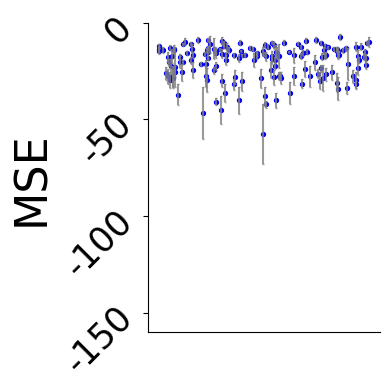

In [42]:
# score scater plot

layer_short = "conv5432"
similarity_metric = "MSE"
sampling_type = "random"
pop_size = 64
each_layer_pop_size_coeff = 4
num_of_pop_resampling = metadata_df_cosine["pop_resampling_id"].max()+1
num_of_reconstruction_repetitions = metadata_df_cosine["gen_rerun_id"].max()+1
col_name= "score"
save_path_root = os.path.join(save_root, f"score_scater")
os.makedirs(save_path_root, exist_ok=True)
image_name_list = metadata_df_cosine["trget_imge_name"].unique()

# set font size
title_font_size = 40
axis_font_size = 32
tick_font_size = 25
legend_font_size = 25

#for img_name in image_name_list:
#    for 

# do the mean and sem by negleting np.nan values
mean_score_g1 =  metadata_df_cosine[(metadata_df_cosine["output_type"] == "best_gen_imgs_RF_masked") & \
                                (metadata_df_cosine["similarity_metric"]==similarity_metric) & (
                                metadata_df_cosine["layer_short"]==layer_short) & (
                                metadata_df_cosine["sub_pop_type"] == sampling_type)&(
                                metadata_df_cosine["pop_size"] == pop_size)].groupby([
                                "trget_imge_name", 'pop_resampling_id', 'gen_rerun_id'])[col_name].mean().reset_index()
score_mean = mean_score_g1.groupby(['pop_resampling_id', "trget_imge_name"])[col_name].mean()
score_std = mean_score_g1.groupby([ 'pop_resampling_id', "trget_imge_name"])[col_name].std()


fig, ax = plt.subplots(figsize=(4, 4))
#x_jitter = np.random.randn(0, 13, len(score_mean))
x_jitter = np.random.random(len(score_mean))*7
ax.errorbar(x_jitter, score_mean, yerr=score_std, color='gray', capsize=1, ls='none', label=None, alpha=0.8)
ax.scatter(x_jitter, score_mean, marker='o', color='blue', label=None, s=8)
# remove the xaixs
ax.set_xticks([])
ax.set_ylim([-160, 0])
ax.set_ylabel("MSE", fontsize=axis_font_size)
ax.set_yticks([-150, -100, -50, 0])
ax.set_yticklabels([-150, -100, -50, 0], fontsize=tick_font_size, rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(save_path_root, f"score_scater_{layer_short}_{similarity_metric}_{sampling_type}_{pop_size}.pdf"), dpi=300)


In [58]:
mean_score_xstd

trget_imge_name
ecoset_10          4.456377
ecoset_11          1.166024
ecoset_12          1.548302
ecoset_14          1.317390
ecoset_16          1.167269
ecoset_26          2.282557
ecoset_31          4.225141
ecoset_33          1.554120
ecoset_49          1.745435
ecoset_7           8.799686
imagenet_116       3.947066
imagenet_14        2.479383
imagenet_18        1.911731
imagenet_26        2.821538
imagenet_35        1.500549
imagenet_5         1.404394
imagenet_52        4.514009
imagenet_58        1.336271
imagenet_7         4.660512
imagenet_8         2.680554
imagenet_83        1.586737
invar_1            2.094186
invar_1_flipped    3.637496
invar_2            2.266268
invar_2_rotated    1.323121
invar_3            4.012552
invar_3_flipped    4.087799
invar_3_rotated    3.922136
invar_4            1.419853
invar_4_flipped    2.242244
n05716342_1492     2.152991
n08524735_17105    2.242529
Name: score, dtype: float64

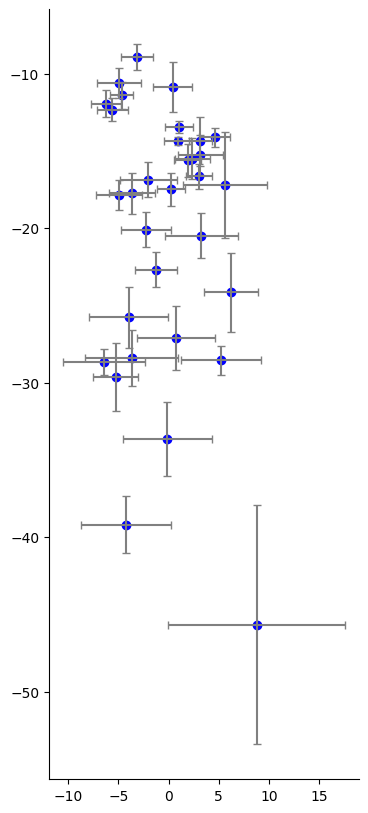

In [60]:
# make scatter plot in y axis is the mean value and x axis is just jittering but each point have two diffrent std bars  one in the x and y axis

x_jitter = np.random.normal(0, 4, len(mean_score_xstd))

fig, ax = plt.subplots(figsize=(4, 10))
# Plot error bars

plt.errorbar(x_jitter, mean_score_mean, xerr=mean_score_xstd, yerr=mean_score_ystd, color='gray', capsize=3, ls='none', label=None)
plt.scatter(x_jitter, mean_score_mean, marker='o', color='blue', label=None)


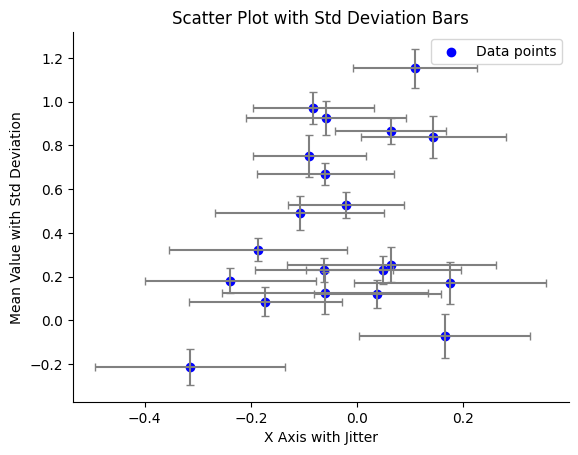

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# Generate sample data
np.random.seed(42)
mean_values = np.random.rand(20)
std_x = np.random.uniform(0.1, 0.2, 20)
std_y = np.random.uniform(0.05, 0.1, 20)

# Create x-axis jitter
x_jitter = np.random.normal(0, std_x, 20)

# Calculate y-axis values with jitter
y_values = mean_values + x_jitter + np.random.normal(0, std_y, 20)

# Create scatter plot
plt.scatter(x_jitter, y_values, marker='o', color='blue', label='Data points')

# Plot error bars
for i in range(len(mean_values)):
    plt.errorbar(x_jitter[i], y_values[i], xerr=std_x[i], yerr=std_y[i], color='gray', capsize=3)

# Set labels and title
plt.xlabel('X Axis with Jitter')
plt.ylabel('Mean Value with Std Deviation')
plt.title('Scatter Plot with Std Deviation Bars')

# Display legend
plt.legend()

# Show the plot
plt.show()
